# AllLife Bank Customer Segmentation_Project_GAP

By: Glen A Patterson

Date: 12-10-2022

## Problem Statment:

1. Help the Marketing team run personalized campaigns to target new customers as well as upsell to existing customers.
2. Help the Operations team to upgrade the service delivery model, to ensure that customer queries are resolved faster.

## Objective:

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Data Dictionary:

1. **Sl_No**: Primary key of the records
2. **Customer Key**: Customer identification number
3. **Average Credit Limit**: Average credit limit of each customer for all credit cards
4. **Total credit cards**: Total number of credit cards possessed by the customer
5. **Total visits bank**: Total number of visits that customer made (yearly) personally to the bank
6. **Total visits online**: Total number of visits or online logins made by the customer (yearly)
7. **Total calls made**: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing the necessary libraries:

In [1]:
# this will help in making the Python code more structured automatically
%load_ext nb_black

# Libraries to help read, save, and manipulate data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
sns.set()

# Library to suppress warnings or deprecation notes
import warnings

warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 300)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# to compute distances
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

<IPython.core.display.Javascript object>

In [2]:
# Load the Microsoft Excel file and call the dataframe "CustomerSegmentation"
CustomerSegmentation = pd.read_excel("Credit+Card+Customer+Data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
# Make a copy of original dataframe "CustomerSegmentation" and call it "data".  We will be modifying this dataframe
data = CustomerSegmentation.copy()

<IPython.core.display.Javascript object>

In [4]:
# Observing the head of the first 10 rows of the dataset to make sure it loaded correctly and examine the data.
data.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


<IPython.core.display.Javascript object>

In [5]:
# Get information about the number of rows and columns in the dataset (rows, columns)
data.shape

(660, 7)

<IPython.core.display.Javascript object>

- We can see that there is 660 rows and 7 columns

In [6]:
# See if there is any duplicated rows
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

- There is no duplicated rows in dataset.

In [7]:
# Information on dataset (data types, format, missing data, ect.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

- There is no missing data in this dataset
- There is 36.2KB memory used
- There is seven "int64" data types

In [8]:
# Explore the Statistics in data and look for outliers in dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


<IPython.core.display.Javascript object>

In [9]:
# dropping the columns "Sl_No" and "Customer Key"
data = data.drop(["Sl_No", "Customer Key"], axis=1)

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

### Univariate analysis:

In [10]:
# function to create labeled barplots
def labeled_barplot(data, feature, figuresize=3, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, figuresize * 6))
    else:
        plt.figure(figsize=(n + 2, figuresize * 6))

    plt.xticks(rotation=90, fontsize=figuresize * 16)
    plt.yticks(fontsize=figuresize * 16)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=25,
            xytext=(0, 10),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


# This is a function that will help us create boxplot and histogram for any input numerical
# variable.
# This function takes the numerical column as the input and returns the boxplots
# and histograms for the variable.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined
    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

#### Observation on Avg_Credit_Limit

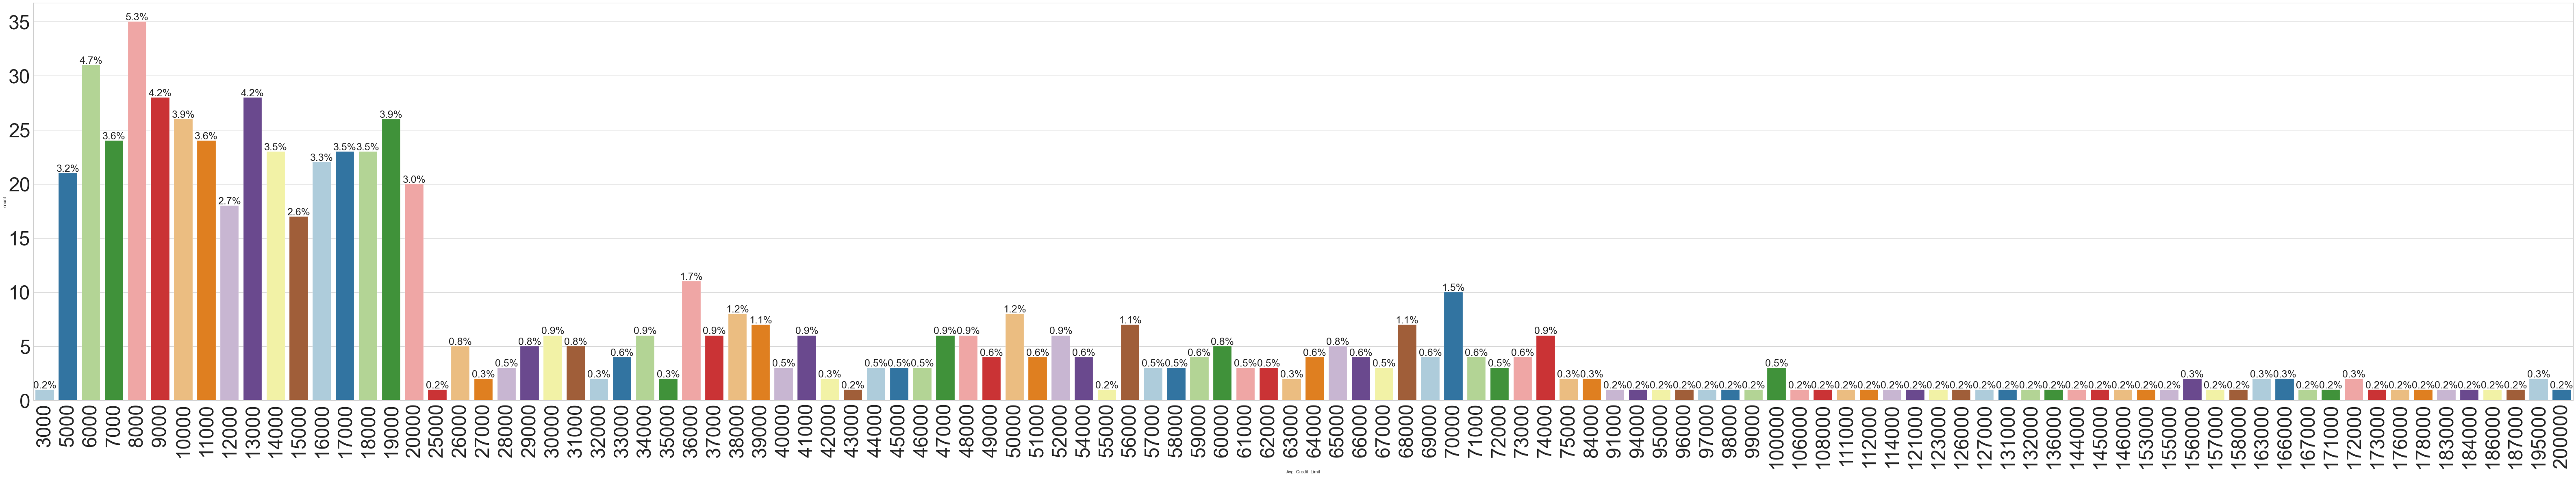

<IPython.core.display.Javascript object>

In [11]:
labeled_barplot(data, "Avg_Credit_Limit", perc=True)

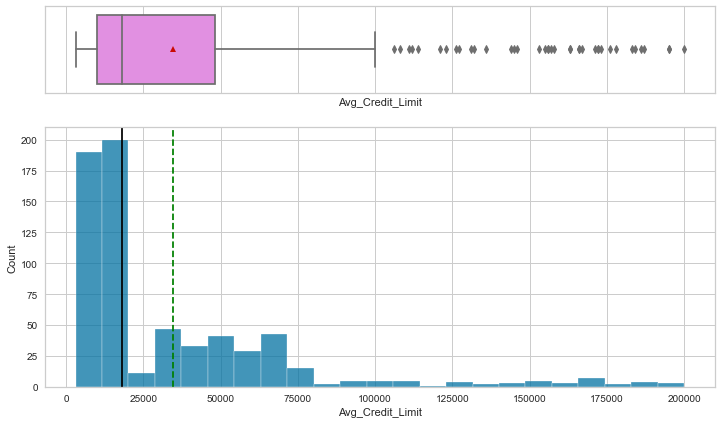

<IPython.core.display.Javascript object>

In [12]:
histogram_boxplot(data, "Avg_Credit_Limit")

- The Median Avg_Credit_Limit is 18,000, the lowest Avg_Credit_Limit is 3,000 and the highest Avg_Credit_Limit is 200,000
- The Avg_Credit_Limit IQR is between 10,000 and 48,000 with a mean of 34,500
- There is many outliers in Avg_Credit_Limit between customers

#### Observation on Total_Credit_Cards

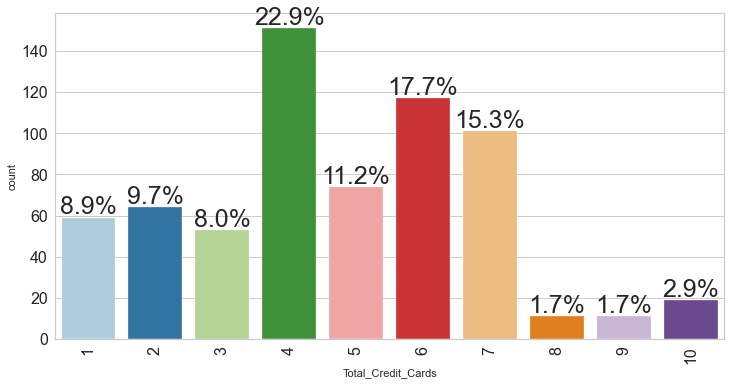

<IPython.core.display.Javascript object>

In [13]:
labeled_barplot(data, "Total_Credit_Cards", 1, perc=True)

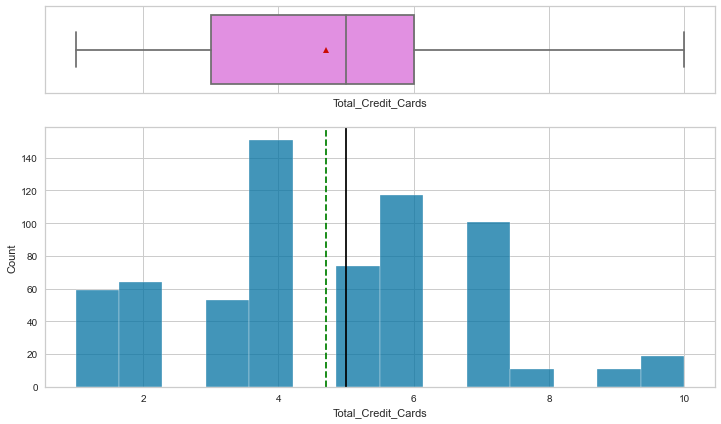

<IPython.core.display.Javascript object>

In [14]:
histogram_boxplot(data, "Total_Credit_Cards")

- 8.9% of the bank's customers have only one credit card
- 9.7% of the bank's customers have two credit cards
- 8.0% of the bank's customers have three credit cards
- 22.9% of the bank's customers have four credit cards
- 11.2% of the bank's customers have five credit cards
- 17.7% of the bank's customers have six credit cards
- 15.3% of the bank's customers have seven credit cards
- 1.7% of the bank's customers have eight credit cards
- 1.7% of the bank's customers have nine credit cards
- 2.9% of the bank's customers have ten credit cards
- There is no outliers in Total_Credit_Cards
- The IQR in Total_Credit_Cards is between 3 and 6 with a median of 5

#### Observation on Total_visits_bank

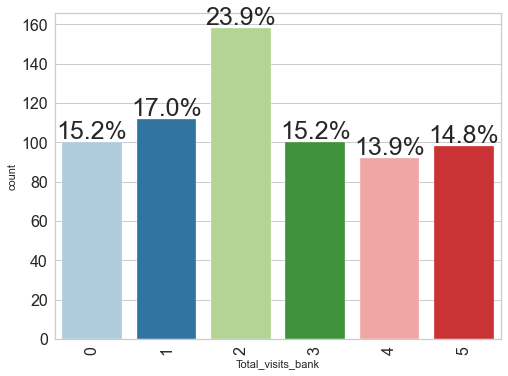

<IPython.core.display.Javascript object>

In [15]:
labeled_barplot(data, "Total_visits_bank", 1, perc=True)

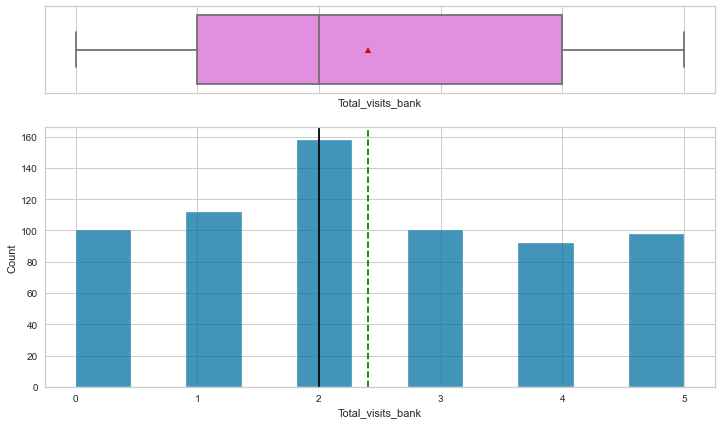

<IPython.core.display.Javascript object>

In [16]:
histogram_boxplot(data, "Total_visits_bank")

- 15.2% of the bank's customers did not personally visit the bank at all. (Yearly Total)
- 17.0% of the bank's customers personally visited the bank only once. (Yearly Total)
- 23.9% of the bank's customers personally visit the bank twice. (Yearly Total)
- 15.2% of the bank's customers personally visit the bank three times. (Yearly Total)
- 13.9% of the bank's customers personally visit the bank four times. (Yearly Total)
- 14.8% of the bank's customers personally visit the bank five times. (Yearly Total)
- There is no outliers in customers Total_visits_bank
- The IQR of Total_visits_bank is between 1 and 4 with median of 2

#### Observation on Total_visits_online

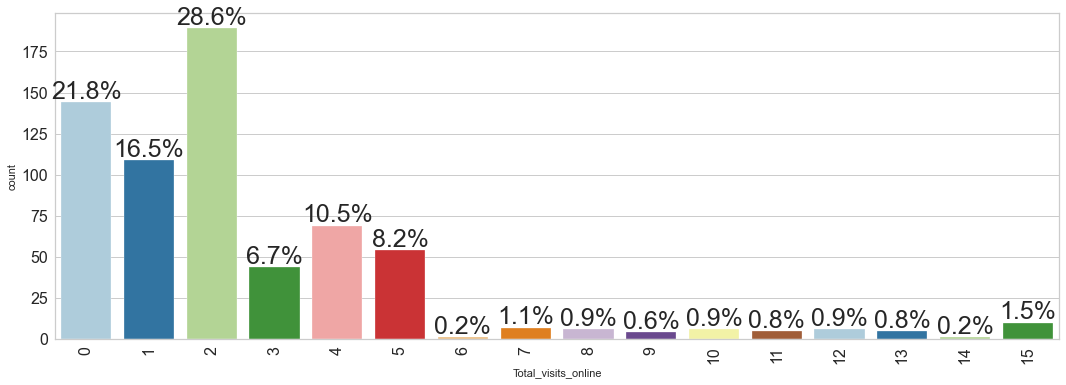

<IPython.core.display.Javascript object>

In [17]:
labeled_barplot(data, "Total_visits_online", 1, perc=True)

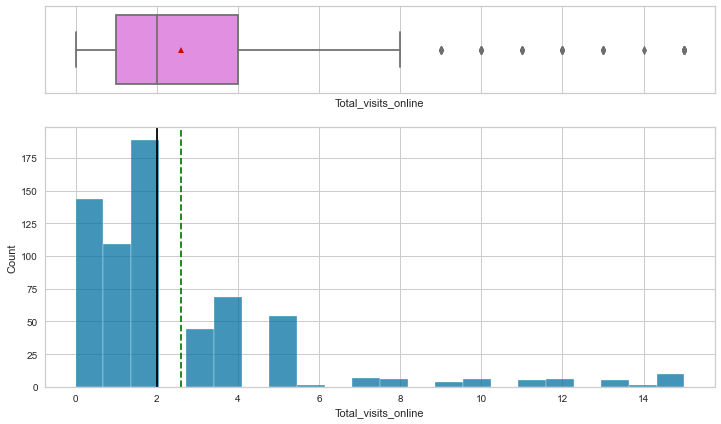

<IPython.core.display.Javascript object>

In [18]:
histogram_boxplot(data, "Total_visits_online")

- 21.8% of the bank's customers never online login visited with the bank. (Yearly Total)
- 16.5% of the bank's customers online login visited with the bank only once. (Yearly Total)
- 28.6% of the bank's customers online login visited with the bank twice. (Yearly Total)
- 6.7% of the bank's customers online login visited with the bank three times. (Yearly Total)
- 10.5% of the bank's customers online login visited with the bank four times. (Yearly Total)
- 8.2% of the bank's customers online login visited with the bank five times. (Yearly Total)
- 7.9% of the bank's customers online login visited with the bank 6 or more times. (Yearly Total)
- There is a few outliers in Total_visits_online greater than 8 login.
- The IQR is between 1 and 4 with median of 2 login visits to the bank yearly total.

#### Observation on Total_calls_made

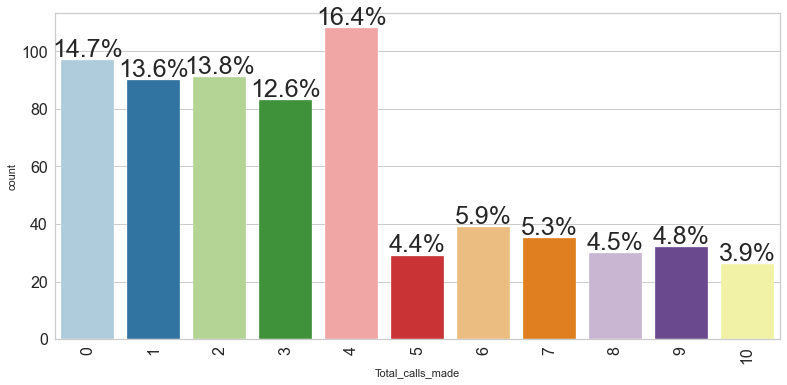

<IPython.core.display.Javascript object>

In [19]:
labeled_barplot(data, "Total_calls_made", 1, perc=True)

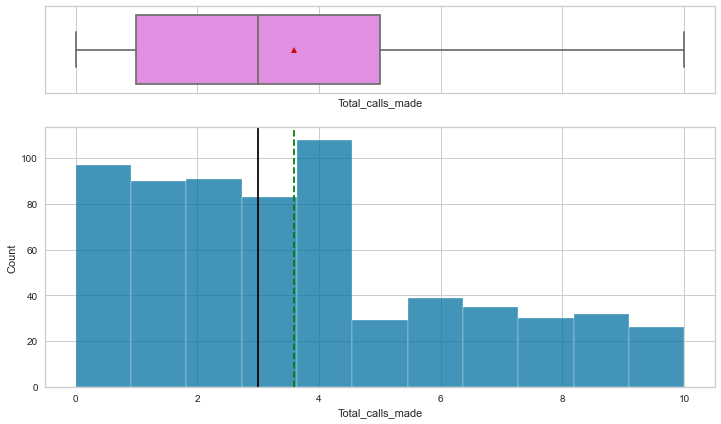

<IPython.core.display.Javascript object>

In [20]:
histogram_boxplot(data, "Total_calls_made")

- 14.7% of the bank's customers never made a call to the bank or its customer service department. (Yearly Total)
- 13.6% of the bank's customers made one call to the bank or its customer service department. (Yearly Total)
- 13.8% of the bank's customers made two calls to the bank or its customer service department. (Yearly Total)
- 12.6% of the bank's customers made three calls to the bank or its customer service department. (Yearly Total)
- 16.4% of the bank's customers made four calls to the bank or its customer service department. (Yearly Total)
- 4.4% of the bank's customers made five calls to the bank or its customer service department. (Yearly Total)
- 5.9% of the bank's customers made six calls to the bank or its customer service department. (Yearly Total)
- 5.3% of the bank's customers made seven calls to the bank or its customer service department. (Yearly Total)
- 4.5% of the bank's customers made eight calls to the bank or its customer service department. (Yearly Total)
- 4.8% of the bank's customers made nine calls to the bank or its customer service department. (Yearly Total)
- 3.9% of the bank's customers made ten calls to the bank or its customer service department. (Yearly Total)
- There is no outliers in Total_calls_made by the customer to the bank
- The Total_calls_made IQR is between 1 and 5 with the median of 3

In [21]:
# selecting numerical columns
num_col = data.select_dtypes(include=np.number).columns.tolist()

<IPython.core.display.Javascript object>

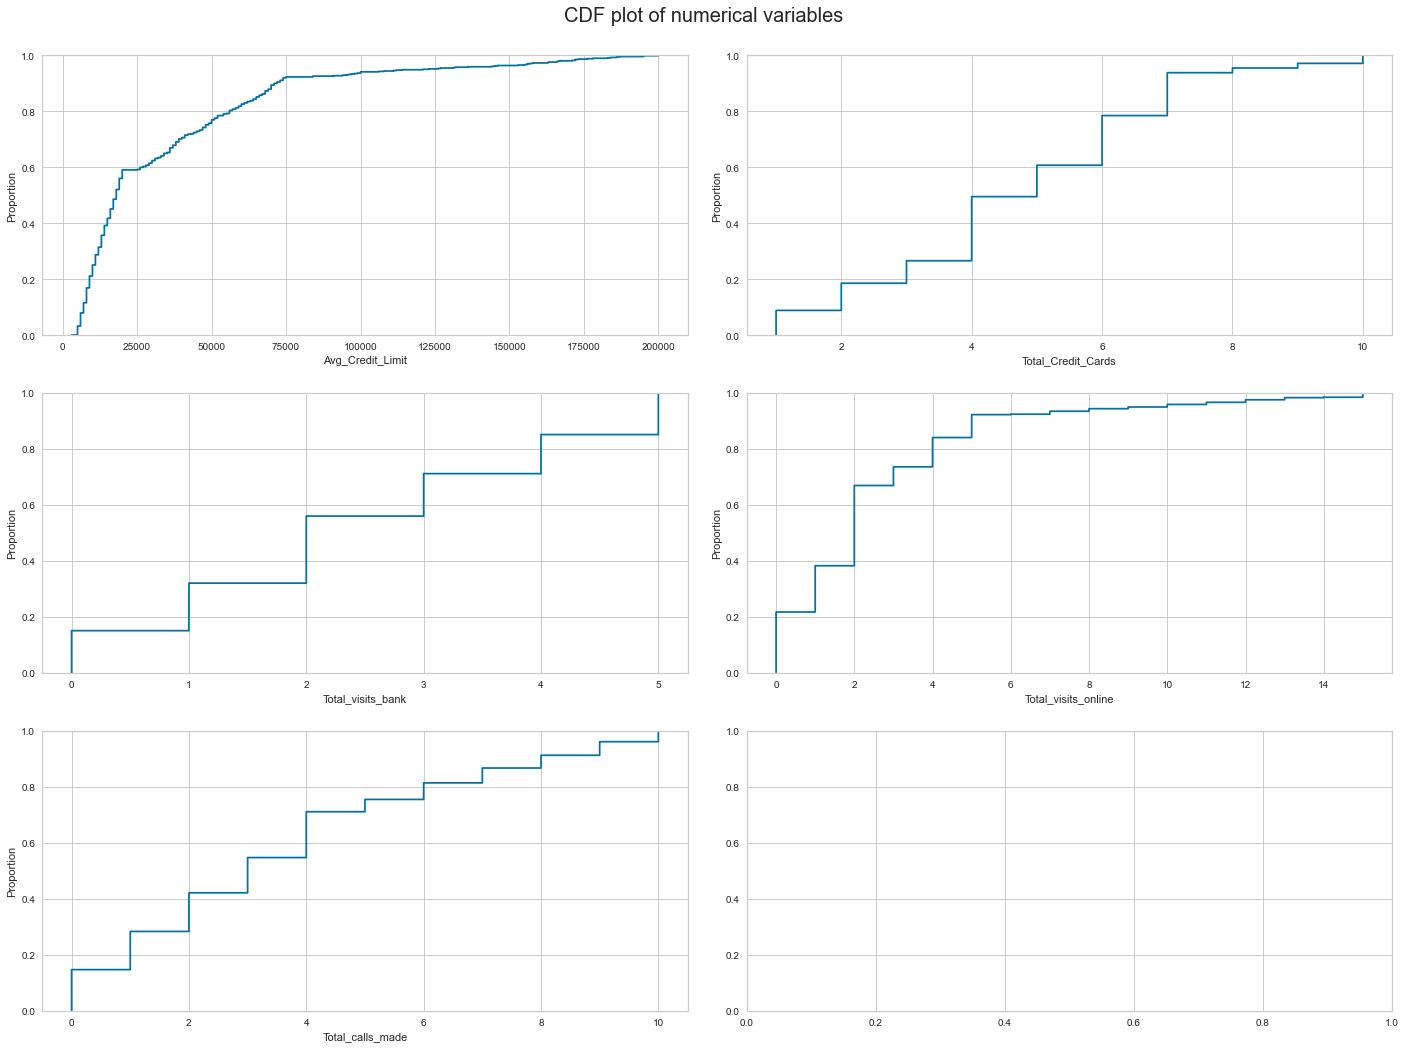

<IPython.core.display.Javascript object>

In [22]:
# The Cumulative Distribution Function(CDF) plot of the dataset
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=data[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=data[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

**Observations**

- 90% of the bank's customers have Avg_Credit_Limit of 65,000 or less.
- 95% of the bank's customers have Total_Credit_Cards of 7 or less.
- 85% of the bank's customers have Total_visits_bank of 4 or less.
- 92% of the bank's customers have Total_visits_online of 5 or less.
- 91% of the bank's customers have Total_calls_made of 8 or less.

### Bivariate Analysis

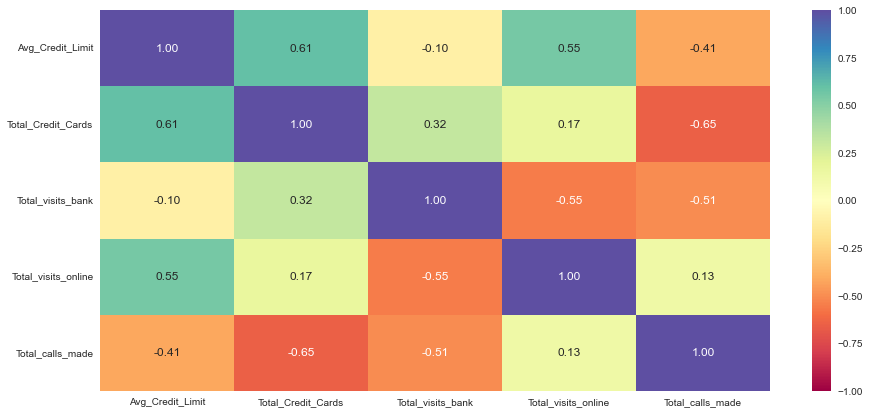

<IPython.core.display.Javascript object>

In [23]:
# creating the heatmap of the dataset
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**

- There is a strong negitive correlation between Total_Credit_Cards and Total_calls_made
- There is a strong positive correlation between Total_Credit_Cards and Avg_Credit_Limit
- There is a positive correlation between Total_visits_online and Avg_Credit_Limit
- There is a negitive correlation between Total_visits_online and Total_visits_bank
- There is a negitive correlation between Total_visits_bank and Total_calls_made
- There is a negitive correlation between Total_calls_made and Avg_Credit_Limit
- There is a positive correlation between Total_visits_bank and Total_Credit_Cards
- There is a small positive correlation between Total_Credit_Cards and Total_visits_online

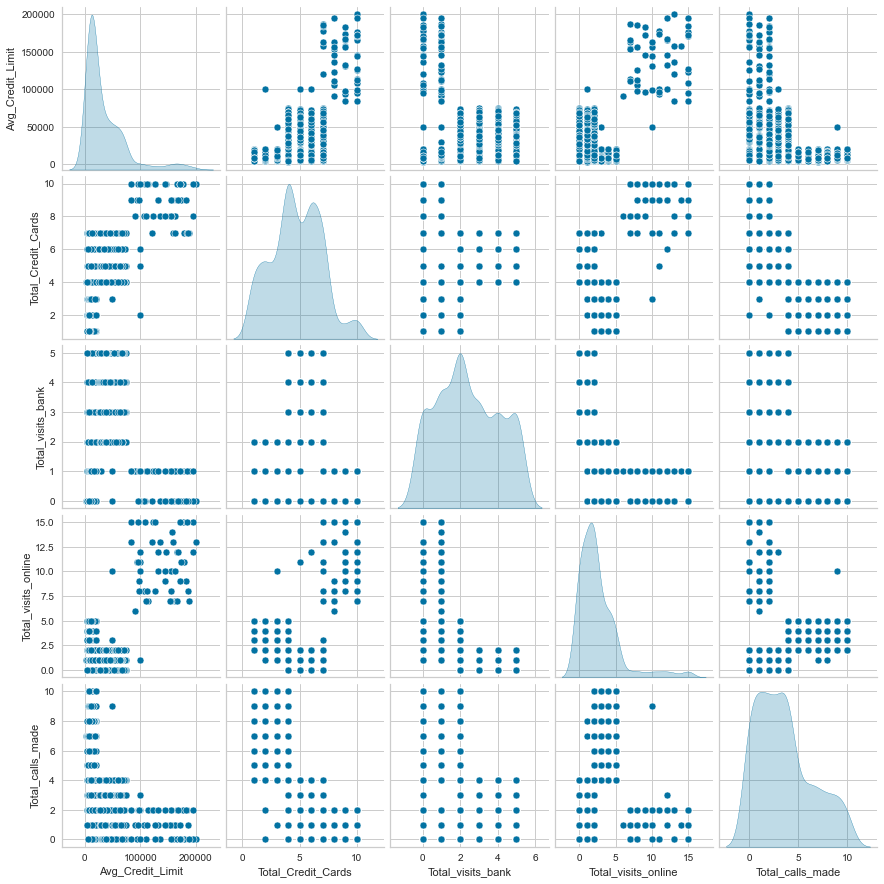

<IPython.core.display.Javascript object>

In [24]:
# creating the pairplot of the dataset
sns.pairplot(data=data, diag_kind="kde")
plt.show()

**Observations**

- The univariate plots on the horizontal axis shows that there could be 3 or 4 clustering customer segmentations.
- Customers with five or more Total_calls_made usually have Avg_Credit_Limit of 25,000 or less.
- Customers with four or less Total_Credit_Cards usually have higher Total_calls_made.
- Customers with two or less Total_visits_bank usually have higher Total_calls_made.
- Customers with five or less Total_visits_online usually have higher Total_calls_made.
- Customers with five or more Total_visits_online usually have Avg_Credit_Limit of 100,000 or more.
- Customers with five or more Total_visits_online usually have Total_Credit_Cards of 5 or more.
- Customers with one or less Total_visits_bank usually have Total_visits_online of 5 or more.
- Customers with two or more Total_visits_bank usually have Avg_Credit_Limit of 80,000 or less.
- Customers with seven or more Total_Credit_Cards usually have Avg_Credit_Limit of 100,000 or more.

## Insights based on EDA

- The Median Avg_Credit_Limit is 18,000, the lowest Avg_Credit_Limit is 3,000 and the highest Avg_Credit_Limit is 200,000
- The Avg_Credit_Limit IQR is between 10,000 and 48,000 with a mean of 34,500
- There is many outliers in Avg_Credit_Limit between customers
- 8.9% of the bank's customers have only one credit card
- 9.7% of the bank's customers have two credit cards
- 8.0% of the bank's customers have three credit cards
- 22.9% of the bank's customers have four credit cards
- 11.2% of the bank's customers have five credit cards
- 17.7% of the bank's customers have six credit cards
- 15.3% of the bank's customers have seven credit cards
- 1.7% of the bank's customers have eight credit cards
- 1.7% of the bank's customers have nine credit cards
- 2.9% of the bank's customers have ten credit cards
- There is no outliers in Total_Credit_Cards
- The IQR in Total_Credit_Cards is between 3 and 6 with a median of 5
- 15.2% of the bank's customers did not personally visit the bank at all. (Yearly Total)
- 17.0% of the bank's customers personally visited the bank only once. (Yearly Total)
- 23.9% of the bank's customers personally visit the bank twice. (Yearly Total)
- 15.2% of the bank's customers personally visit the bank three times. (Yearly Total)
- 13.9% of the bank's customers personally visit the bank four times. (Yearly Total)
- 14.8% of the bank's customers personally visit the bank five times. (Yearly Total)
- There is no outliers in customers Total_visits_bank
- The IQR of Total_visits_bank is between 1 and 4 with median of 2
- 21.8% of the bank's customers never online login visited with the bank. (Yearly Total)
- 16.5% of the bank's customers online login visited with the bank only once. (Yearly Total)
- 28.6% of the bank's customers online login visited with the bank twice. (Yearly Total)
- 6.7% of the bank's customers online login visited with the bank three times. (Yearly Total)
- 10.5% of the bank's customers online login visited with the bank four times. (Yearly Total)
- 8.2% of the bank's customers online login visited with the bank five times. (Yearly Total)
- 7.9% of the bank's customers online login visited with the bank 6 or more times. (Yearly Total)
- There is a few outliers in Total_visits_online greater than 8 login.
- The IQR is between 1 and 4 with median of 2 login visits to the bank yearly total.
- 14.7% of the bank's customers never made a call to the bank or its customer service department. (Yearly Total)
- 13.6% of the bank's customers made one call to the bank or its customer service department. (Yearly Total)
- 13.8% of the bank's customers made two calls to the bank or its customer service department. (Yearly Total)
- 12.6% of the bank's customers made three calls to the bank or its customer service department. (Yearly Total)
- 16.4% of the bank's customers made four calls to the bank or its customer service department. (Yearly Total)
- 4.4% of the bank's customers made five calls to the bank or its customer service department. (Yearly Total)
- 5.9% of the bank's customers made six calls to the bank or its customer service department. (Yearly Total)
- 5.3% of the bank's customers made seven calls to the bank or its customer service department. (Yearly Total)
- 4.5% of the bank's customers made eight calls to the bank or its customer service department. (Yearly Total)
- 4.8% of the bank's customers made nine calls to the bank or its customer service department. (Yearly Total)
- 3.9% of the bank's customers made ten calls to the bank or its customer service department. (Yearly Total)
- There is no outliers in Total_calls_made by the customer to the bank
- The Total_calls_made IQR is between 1 and 5 with the median of 3
- 90% of the bank's customers have Avg_Credit_Limit of 65,000 or less.
- 95% of the bank's customers have Total_Credit_Cards of 7 or less.
- 85% of the bank's customers have Total_visits_bank of 4 or less.
- 92% of the bank's customers have Total_visits_online of 5 or less.
- 91% of the bank's customers have Total_calls_made of 8 or less.
- There is a strong negitive correlation between Total_Credit_Cards and Total_calls_made
- There is a strong positive correlation between Total_Credit_Cards and Avg_Credit_Limit
- There is a positive correlation between Total_visits_online and Avg_Credit_Limit
- There is a negitive correlation between Total_visits_online and Total_visits_bank
- There is a negitive correlation between Total_visits_bank and Total_calls_made
- There is a negitive correlation between Total_calls_made and Avg_Credit_Limit
- There is a positive correlation between Total_visits_bank and Total_Credit_Cards
- There is a small positive correlation between Total_Credit_Cards and Total_visits_online
- The univariate plots on the horizontal axis shows that there could be 3 or 4 clustering customer segmentations.
- Customers with five or more Total_calls_made usually have Avg_Credit_Limit of 25,000 or less.
- Customers with four or less Total_Credit_Cards usually have higher Total_calls_made.
- Customers with two or less Total_visits_bank usually have higher Total_calls_made.
- Customers with five or less Total_visits_online usually have higher Total_calls_made.
- Customers with five or more Total_visits_online usually have Avg_Credit_Limit of 100,000 or more.
- Customers with five or more Total_visits_online usually have Total_Credit_Cards of 5 or more.
- Customers with one or less Total_visits_bank usually have Total_visits_online of 5 or more.
- Customers with two or more Total_visits_bank usually have Avg_Credit_Limit of 80,000 or less.
- Customers with seven or more Total_Credit_Cards usually have Avg_Credit_Limit of 100,000 or more.

## Data Preprocessing

In [25]:
# Create a copy of dataset "data" and call it "df"
df = data.copy()

<IPython.core.display.Javascript object>

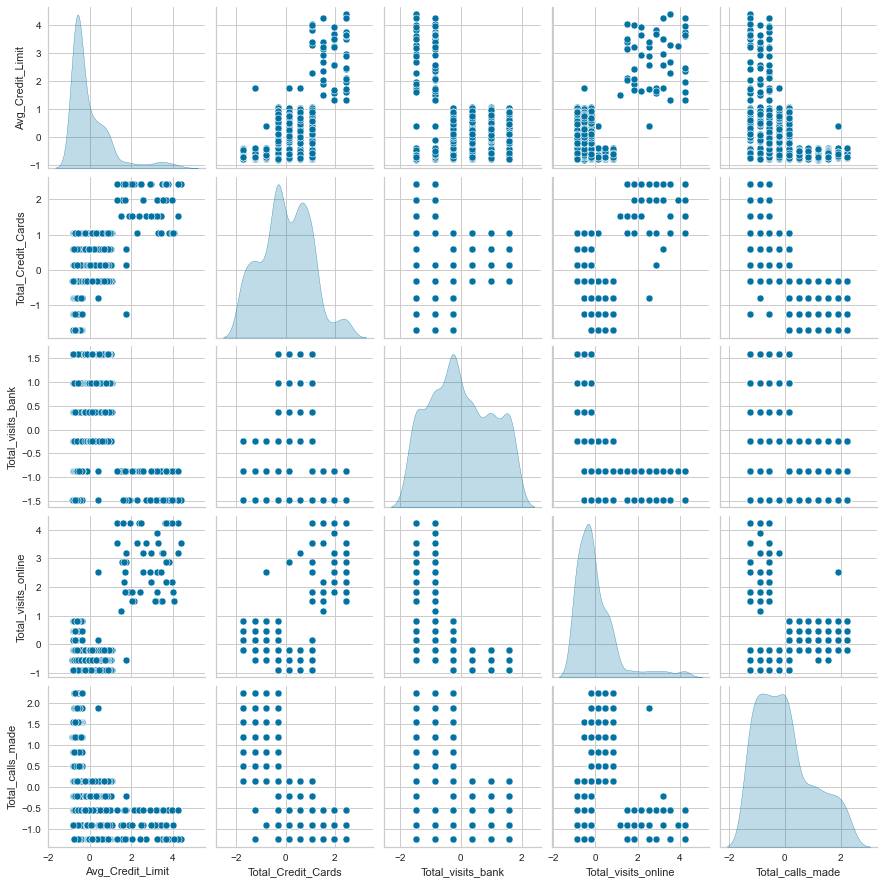

<IPython.core.display.Javascript object>

In [26]:
# convert dataset of each column to the same scale called zscore
df_Scaled = df.apply(zscore)
sns.pairplot(df_Scaled, diag_kind="kde")

## K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9905775320522585
Number of Clusters: 6 	Average Distortion: 0.9429789712808515
Number of Clusters: 7 	Average Distortion: 0.9093520750235037
Number of Clusters: 8 	Average Distortion: 0.8941429068700529
Number of Clusters: 9 	Average Distortion: 0.8680238553282954
Number of Clusters: 10 	Average Distortion: 0.8403915270105949


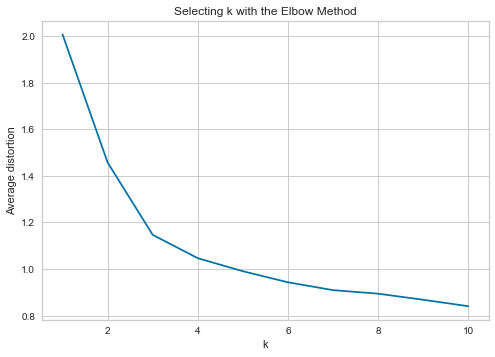

<IPython.core.display.Javascript object>

In [27]:
# creating ten possible values for k and calling it clusters
clusters = range(1, 11)
# creating a list and calling it meanDistortions
meanDistortions = []

# looping through all ten clusters to find appropriate value of k
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df_Scaled)
    prediction = model.predict(df_Scaled)
    distortion = (
        sum(np.min(cdist(df_Scaled, model.cluster_centers_, "euclidean"), axis=1))
        / df_Scaled.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

# plotting the Elbow curve to select the appropriate value for k
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**Appropriate value for k seems to be 3 or 4.**

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2717470361089752)
For n_clusters = 6, the silhouette score is 0.25545029453623114)
For n_clusters = 7, the silhouette score is 0.24782254653773372)
For n_clusters = 8, the silhouette score is 0.22691166866115184)
For n_clusters = 9, the silhouette score is 0.21228719551323377)


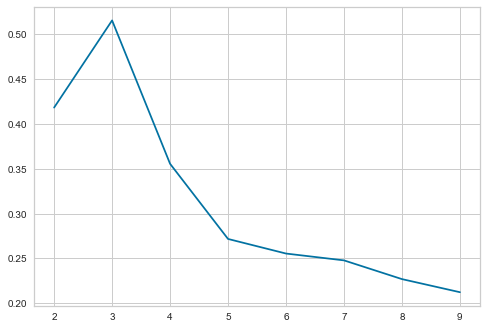

<IPython.core.display.Javascript object>

In [28]:
# checking the silhouette scores
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((df_Scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_Scaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

# plotting the silhouette scores
plt.plot(cluster_list, sil_score)
plt.show()

**Silhouette score for 3 is higher than that for 4. So, we will choose 3 as value of k.**

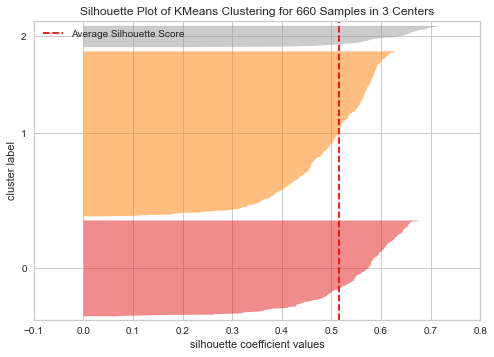

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [29]:
# Plot of clusters with silhouette coefficients using k of 3
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(df_Scaled)
visualizer.show()

In [30]:
# using three as the number of clusters for kmeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_Scaled)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [31]:
# adding kmeans cluster labels to the original and scaled dataframes

df["K_means_Clusters"] = kmeans.labels_
df_Scaled["K_means_Clusters"] = kmeans.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [32]:
# find the mean of each column and groupby K_means_Clusters
cluster_profile = df.groupby("K_means_Clusters").mean()

<IPython.core.display.Javascript object>

In [33]:
# find the count in each cluster and add column in dataframe
cluster_profile["K_means_Cluster_count"] = (
    df.groupby("K_means_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [34]:
# displaying the cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_Cluster_count
K_means_Clusters,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

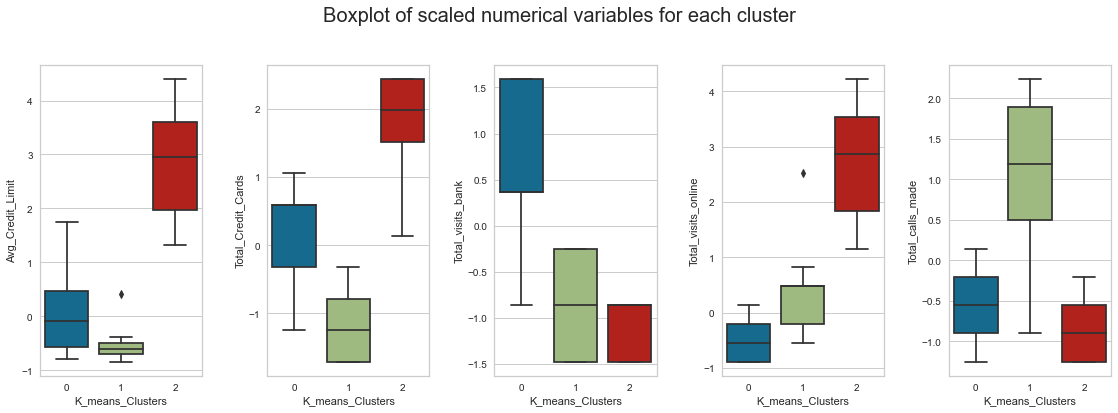

<IPython.core.display.Javascript object>

In [35]:
# creating boxplot for the scaled variables in each cluster
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(
        ax=axes[i], y=df_Scaled[num_col[counter]], x=df_Scaled["K_means_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

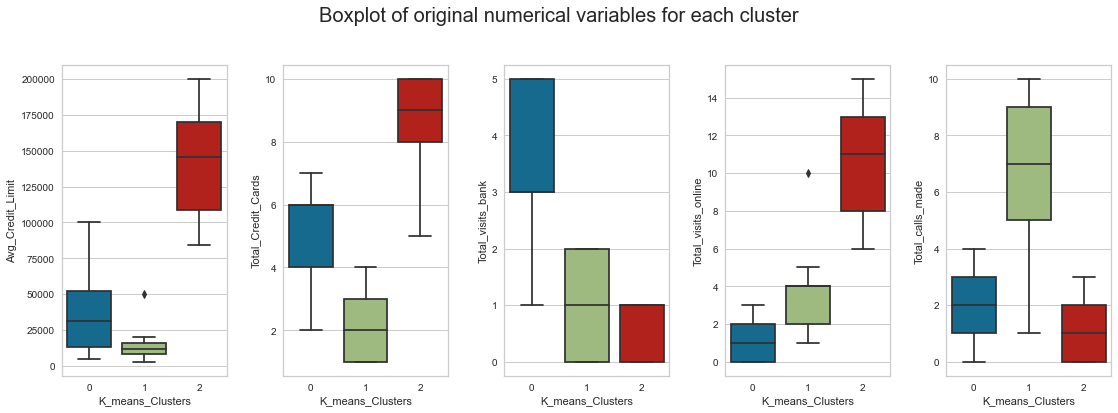

<IPython.core.display.Javascript object>

In [36]:
# creating a boxplot for the original variables in each cluster
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(ax=axes[i], y=df[num_col[counter]], x=df["K_means_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 0**:
    - Total_visits_bank is the highest for this group of bank customers.
    - Majority of the banks customers are in this group.  It is the banks largest group.
    - This group of customers like banking in person.
   
- **Cluster 1**:
    - Total_calls_made is the highest for this group of bank customers.
    - This is the banks second largest group of customers.
    - This group have the lowest Avg_Credit_Limit at a mean of 12,100.
    
- **Cluster 2**:
    - Total_visits_online is the highest for this group of bank customers.
    - Avg_Credit_Limit is the highest for this group of bank customers at a mean of 141,000.
    - Total_Credit_Cards is the highest for this group of bank customers.
    - This is the smallest group of customers compared to the other groups.
    - This group of customers like banking online.

## Hierarchical Clustering

In [37]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_Scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_Scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8788676940541079.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8860521900934342.
Cophenetic correlation for Euclidean distance and average linkage is 0.9168725782090766.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9133393931042242.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8978014062578786.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8623270916886306.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9160784250471772.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9109044268579872.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8959952526724227.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6550023123197868.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8467618899578886.
Cophenetic co

<IPython.core.display.Javascript object>

**Observations**

- We see that the best Cophenetic correlation is the Euclidean distance with average linkage at 0.9168725782090766.

In [38]:
# list of different linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# Checking cophenetic correlation for each linkage method
high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(df_Scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(df_Scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.8788676940541079.
Cophenetic correlation for complete linkage is 0.8860521900934342.
Cophenetic correlation for average linkage is 0.9168725782090766.
Cophenetic correlation for centroid linkage is 0.9134704636213649.
Cophenetic correlation for ward linkage is 0.774233615737438.
Cophenetic correlation for weighted linkage is 0.9133393931042242.


<IPython.core.display.Javascript object>

In [39]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9168725782090766, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**Observations**

- We see that the best Cophenetic correlation is the Euclidean distance with average linkage at 0.9168725782090766.

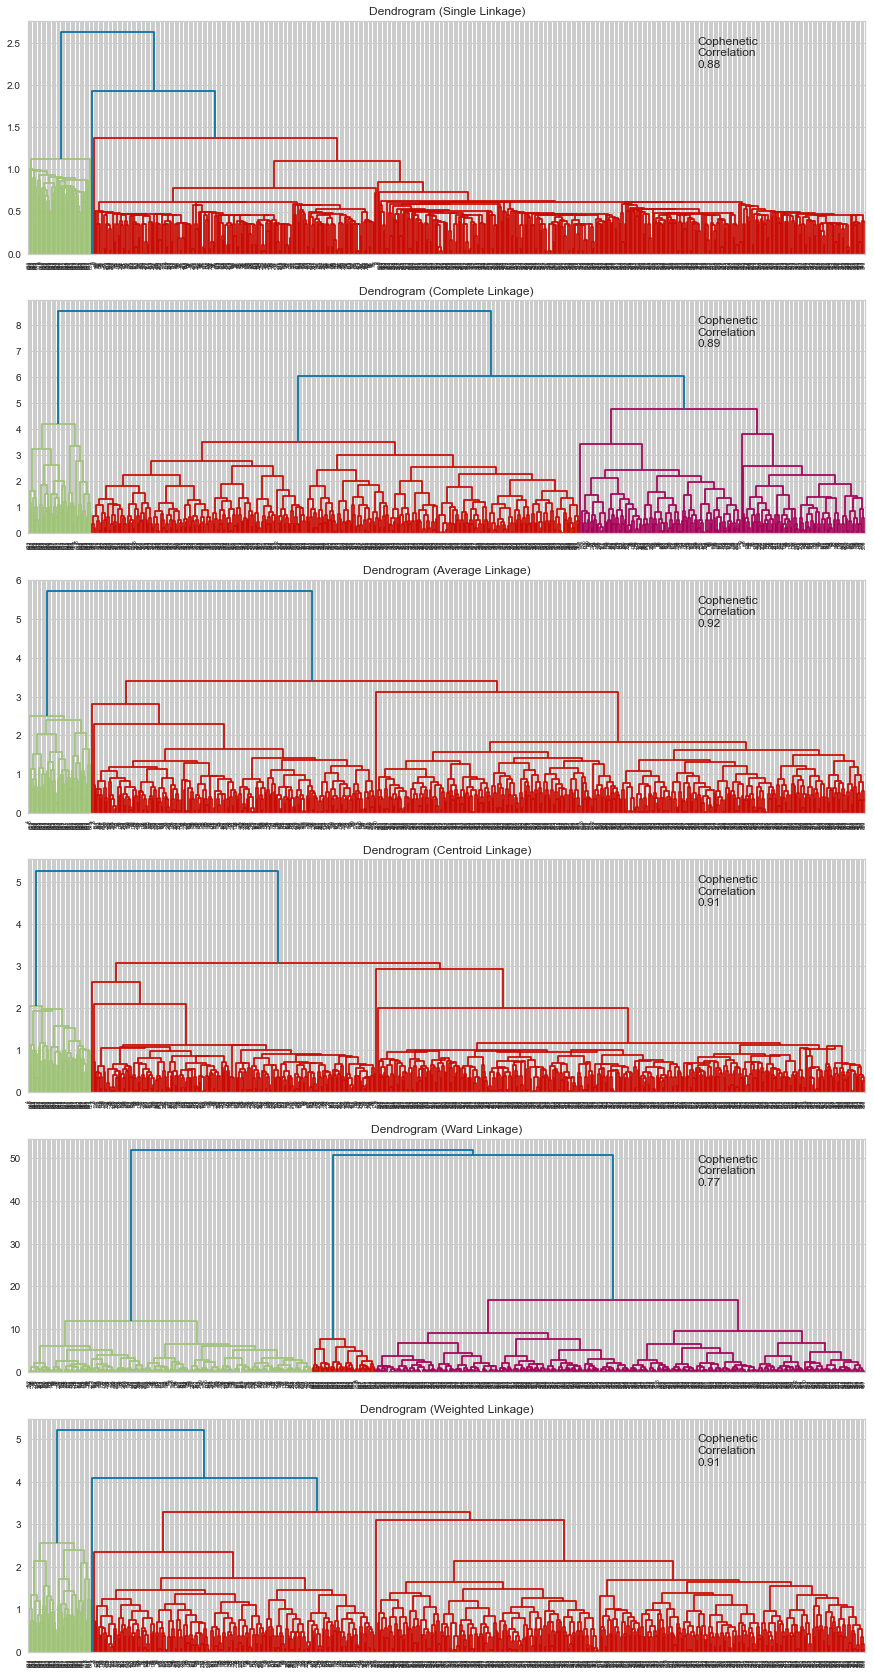

<IPython.core.display.Javascript object>

In [40]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df_Scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_Scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

**Observations**

- 3 would be the appropriate number of the clusters as shown from the dendrograms above. 

In [41]:
# creating a model with a cluster of three
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel.fit(df_Scaled)

AgglomerativeClustering(n_clusters=3)

<IPython.core.display.Javascript object>

In [42]:
# adding hierarchical cluster labels to the original and scaled dataframes

df_Scaled["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [43]:
# find the mean of each column and groupby HC_Clusters
cluster_profile2 = df.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [44]:
# find the count in each cluster and add column in dataframe
cluster_profile2["HC_Cluster_count"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [45]:
# displaying the cluster profiles
cluster_profile2.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_Clusters,HC_Cluster_count
HC_Clusters,,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,0.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,1.000000,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50


<IPython.core.display.Javascript object>

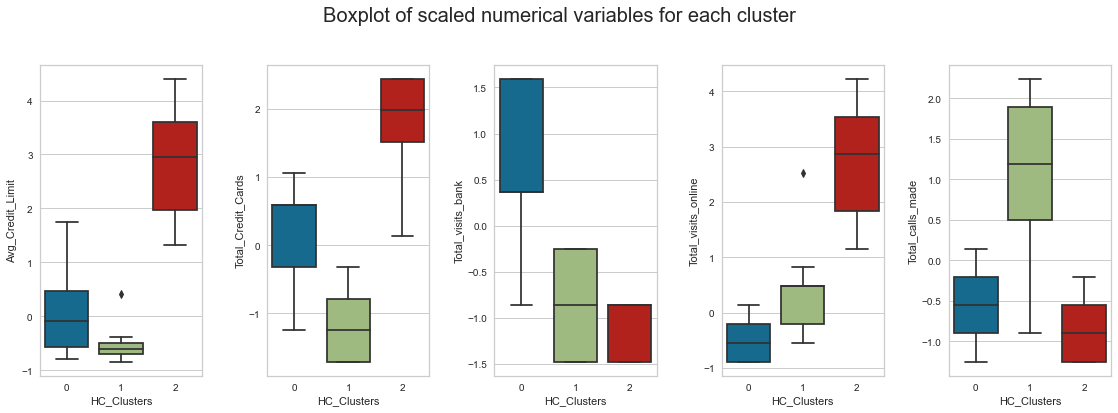

<IPython.core.display.Javascript object>

In [46]:
# creating boxplot for the scaled variables in each cluster
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(
        ax=axes[i], y=df_Scaled[num_col[counter]], x=df_Scaled["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

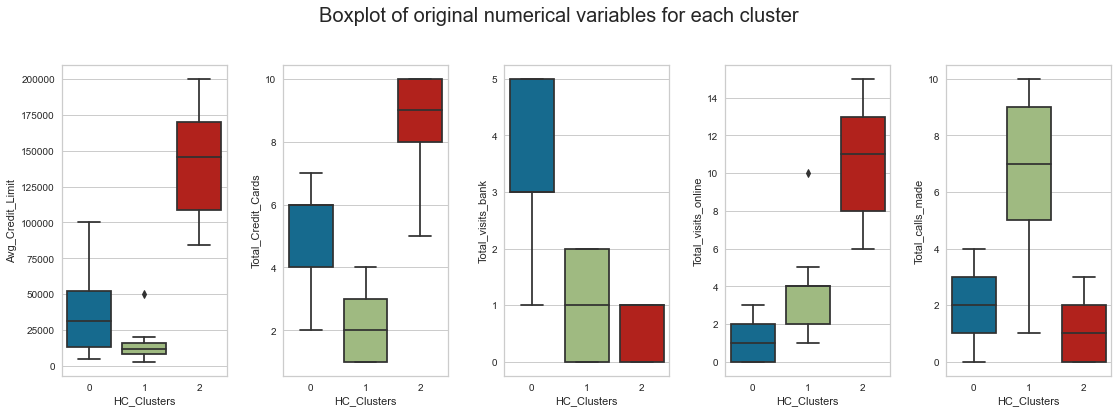

<IPython.core.display.Javascript object>

In [47]:
# creating a boxplot for the original variables in each cluster
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(ax=axes[i], y=df[num_col[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 0**:
    - Total_visits_bank is the highest for this group of bank customers.
    - Majority of the banks customers are in this group.  It is the banks largest group.
    - This group of customers like banking in person.
   
- **Cluster 1**:
    - Total_calls_made is the highest for this group of bank customers.
    - This is the banks second largest group of customers.
    - This group have the lowest Avg_Credit_Limit at a mean of 12,100.
    
- **Cluster 2**:
    - Total_visits_online is the highest for this group of bank customers.
    - Avg_Credit_Limit is the highest for this group of bank customers at a mean of 141,000.
    - Total_Credit_Cards is the highest for this group of bank customers.
    - This is the smallest group of customers compared to the other groups.
    - This group of customers like banking online.

## K-means vs Hierarchical Clustering

- Both methods produced the same results with the same grouping.
- Both K-means and Hierarchical Clustering equally separated the bank's customer base.

## Business Recommendations

- **Cluster 0**:
    - Majority of the banks customers are in this group.  It is the banks largest group.
    - This group of customers like banking in person.
    - Accelerate completion of manual and time-consuming tasks with intelligent automation.
    - In-person banking relationships can help customers craft a business account tailored to their specific needs.
    - An ideal relationship would be a blend of online banking for your day-to-day transactions and a personal relationship with the bank to assist with bigger needs.
    - Some services still require customers to go into the banks to sign documents.
   
- **Cluster 1**:
    - This is the banks second largest group of customers.
    - This group of customers like calling the bank for their banking needs.
    - This group have the lowest Avg_Credit_Limit at a mean of 12,100.
    - Faster answers with self-service over the phone.
    - Offer customers the option to make payments over the phone.
    - Reduce strain on agents call center and empower customers to quickly solve their needs over the phone.
    - Have great communicate with customers through text, phone, online chat, and social media.
    
- **Cluster 2**:
    - This group of customers like banking online.
    - This group has the highest Avg_Credit_Limit at a mean of 141,000.
    - Customers in this group have many different Credit Cards and higher credit limits.
    - This is the smallest group of customers compared to the other groups.
    - Meet customer expectations with a seamless online digital experience.
    - Enable customers to check their account, update their preferences, make online check deposits, complete payments all online.
    - Since this group of customers are banking online, try to entice customers to go paperless to save operation costs.
    - Offer the best digital banking experiences with functional mobile apps and websites with robust features.
    
    
    